# Advanced Tutorial 1: Testing Significance with Monte Carlo SSA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/ssalib/blob/main/notebooks/A1_montecarlo_ssa.ipynb)

**Overview** Monte Carlo SSA is used to test the significance of SSA components [[1]](#ref-1). It generates random surrogate copies of the time series decomposed with SSA, preserving the autocorrelation structure of the original series. The matrix of each surrogate time series is projected onto the singular system of the SSA decomposition. For each singular value obtained from the original decomposition, if the value predominantly exceeds the corresponding surrogate-projected values, this singular value can be considered significant. This allows us to reject the null hypothesis that the component results from an autoregressive stochastic process of that order, with the confidence level determined by the distribution of surrogate-projected values.

In this tutorial, you will ll learn:
- How to use `MonteCarloSSA` to evaluate the significance of SSA components.

## Data

* We use the sea surface temperature `sst` time series.

In [1]:
import matplotlib.pyplot as plt
from ssalib import MonteCarloSSA
from ssalib.datasets import load_sst

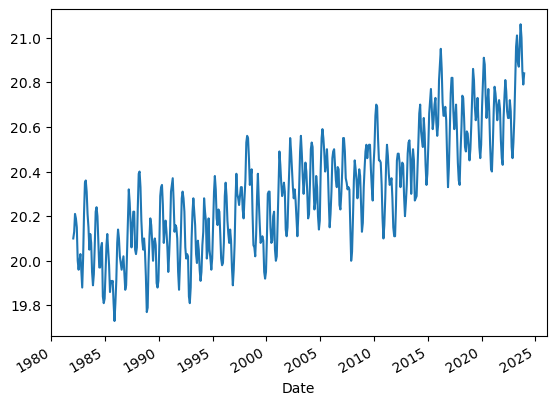

In [2]:
sst = load_sst()
_ = sst.plot()

## Monte Carlos SSA: Initialization

* `MonteCarloSSA` is a child class of `SingularSpectrumAnalysis`.
* During initialization, an autoregressive (AR) model is fitted to the time series.
* The best model up to `ar_model_max` is kept depending on the selected `criterion`, either the Bayesian Information Criterion (`'bic'`) or the Akaike Information Criterion (`'aic'`).
* After fitting, `n_surrogates` surrogate data are generated using the fitted model.
* These surrogates have a similar auto-correlation structure to the original time series, although they are random. Any seemingly cyclical components can be considered spurious and due to the memory (autoregressive coefficients) of the time series.
* A `random_seed` can be provided to ensure the reproducibility of the results.

**Notes**
- The original paper about MonteCarlo SSA used AR1 process (i.e., an autoregressive model of order 1).
- The process can be computationally intensive, especially for long time series.

In [9]:
# Monte Carlo SSA
ssa = MonteCarloSSA(
    sst,
    svd_solver='sklearn_randomized',
    ar_order_max=1,  # default
    criterion='bic',  # default
    n_surrogates=100,  # default
    random_seed=0
)

* We can access the surrogates with the `MonteCarloSSA.surrogates` attribute.

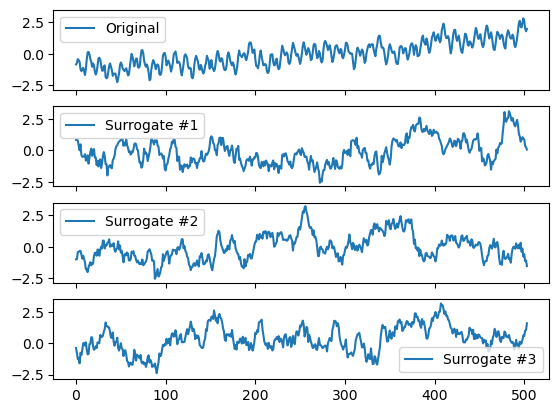

In [10]:
# Visualization of the first three surrogates
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True)
axes[0].plot(ssa._timeseries_pp, label='Original')
axes[0].legend()
for i in range(1, 4):
    axes[i].plot(ssa.surrogates[i], label=f'Surrogate #{i}')
    axes[i].legend()

After decomposition,
* the `MonteCarloSSA.plot(kind='values')` method is modified to show the distribution of the surrogates.
* We can pass the `confidence_level` argument to
* By default, the projected values are symetric (two-tailed), meaning that for a confidence level of 0.95, the interval is bound at percentile 2.5 and 97.5.
* On can disable the

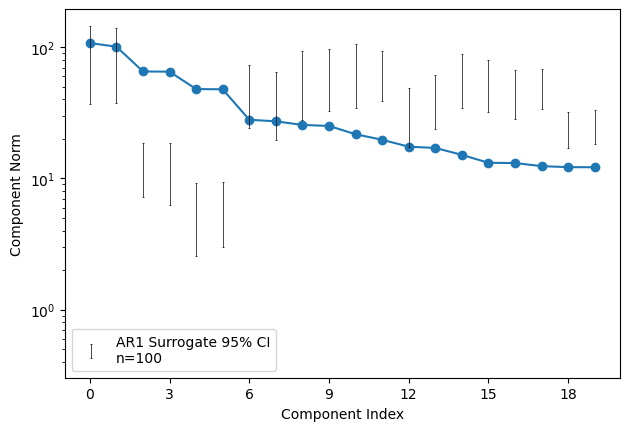

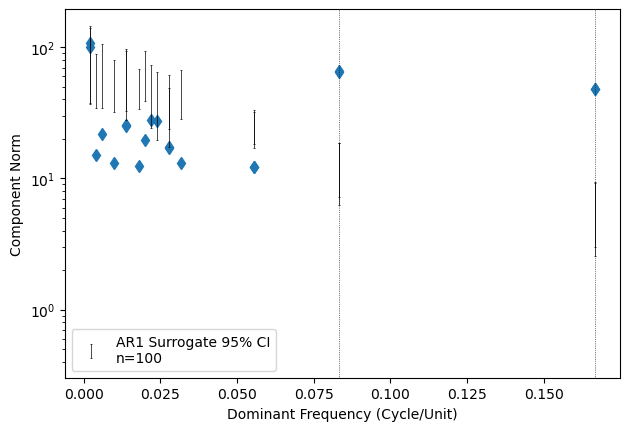

In [19]:
ssa.decompose(n_components=20)
fig, ax = ssa.plot(n_components=20, confidence_level=.95, marker='o')
fig, ax = ssa.plot(
    n_components=20,
    rank_by='freq',
    confidence_level=.95,
    marker='d',
    ls='None'
)
_ = ax.axvline(1 / 12, color='k', lw=.5, ls=':')  # annual freq
_ = ax.axvline(2 / 12, color='k', lw=.5, ls=':')  # semi-annual freq

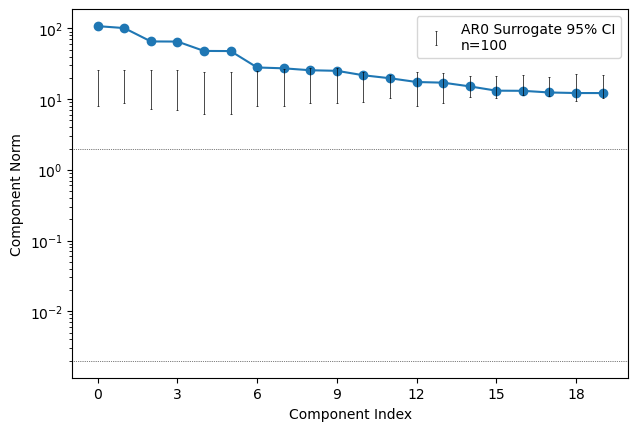

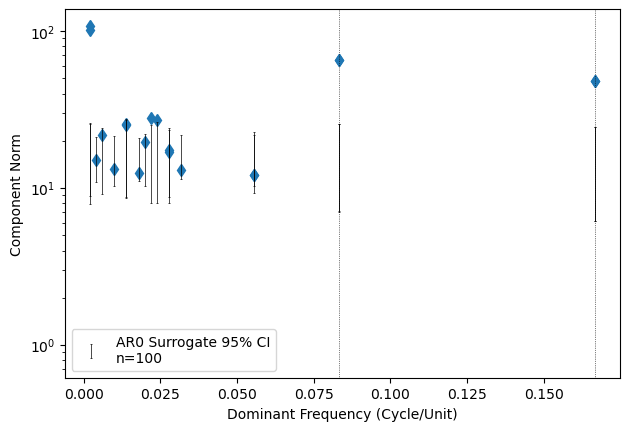

In [32]:
# Monte Carlo SSA
ssa = MonteCarloSSA(
    sst,
    svd_solver='sklearn_randomized',
    ar_order_max=0,  # default
    criterion='bic',  # default
    n_surrogates=100,  # default
    random_seed=0
)
ssa.decompose(n_components=20)
fig, ax = ssa.plot(n_components=20, confidence_level=.95, marker='o')
import numpy as np
m, n = ssa.svd_matrix.shape
_ = ax.axhline((1+np.sqrt(m/n)), color='k', lw=.5, ls=':')
_ = ax.axhline((1-np.sqrt(m/n)), color='k', lw=.5, ls=':')
fig, ax = ssa.plot(
    n_components=20,
    rank_by='freq',
    confidence_level=.95,
    marker='d',
    ls='None'
)

_ = ax.axvline(1 / 12, color='k', lw=.5, ls=':')  # annual freq
_ = ax.axvline(2 / 12, color='k', lw=.5, ls=':')  # semi-annual freq
# Marchenko–Pastur law


1. <span id='ref-1'></span> to add

Here's the complete explanation in markdown:

# Singular Values of Rectangular Random Matrices

For a rectangular matrix of size n×m with aspect ratio $$\gamma = \frac{m}{n}$$, the theoretical singular values follow these bounds:

## Key Formulas

### 1. Largest Singular Value
The largest singular value ($$\sigma_{\text{max}}$$) approaches:

$$
\sigma_{\text{max}} \approx \sqrt{n}(1 + \sqrt{\gamma})
$$

### 2. Smallest Non-zero Singular Value
The smallest non-zero singular value ($$\sigma_{\text{min}}$$) approaches:

$$
\sigma_{\text{min}} \approx \sqrt{n}|1 - \sqrt{\gamma}|
$$

### 3. Number of Non-zero Singular Values
The total count of non-zero singular values is:

$$
r = \min(n,m)
$$

## Examples

### Square Matrix (n=1000, m=1000)
* $$\gamma = 1$$
* $$\sigma_{\text{max}} \approx \sqrt{1000}(1 + 1) = 2\sqrt{1000} \approx 63.25$$
* $$\sigma_{\text{min}} \approx 0$$

### Tall Matrix (n=1000, m=500)
* $$\gamma = 0.5$$
* $$\sigma_{\text{max}} \approx \sqrt{1000}(1 + \sqrt{0.5}) \approx 53.98$$
* $$\sigma_{\text{min}} \approx \sqrt{1000}|1 - \sqrt{0.5}| \approx 9.26$$

### Wide Matrix (n=500, m=1000)
* $$\gamma = 2$$
* $$\sigma_{\text{max}} \approx \sqrt{500}(1 + \sqrt{2}) \approx 53.98$$
* Has $$m-n = 500$$ zero singular values

## Marchenko-Pastur Distribution

The eigenvalues (squares of singular values) follow the Marchenko-Pastur density:

$$
\rho(\lambda) = \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2\pi\gamma\lambda}
$$

where the edges of the support are given by:

$$
\lambda_{\pm} = (1 \pm \sqrt{\gamma})^2
$$

## Important Properties

1. The aspect ratio $$\gamma$$ determines the shape of the singular value spectrum
2. Wide matrices ($$\gamma > 1$$) always have zero singular values
3. Tall matrices ($$\gamma < 1$$) tend to be better conditioned
4. The distribution is universal for random matrices with i.i.d. entries (mean 0, variance 1)
5. The convergence to these theoretical values improves with larger matrix dimensions

## Applications

* Dimensionality reduction
* Random projections
* Compressed sensing
* Matrix approximation
* Statistical signal processing
* Machine learning regularization

This theory provides fundamental insights into the behavior of random matrices and guides practical applications in data science, signal processing, and machine learning.